In [1]:
import PyPlot
using NearestNeighbors
using Vec
using SplineUtils
using RoadwayNetworks
using GeomUtils
using LightGraphs
using UrbanNetworkDemos

# Some LightGraphs stuff

In [ ]:
G = DiGraph()
vertex_to_id_dict = Dict{Int,Int}()
id_to_vertex_dict = Dict{Int,Int}()
edge_to_id_dict = Dict{Int,Int}()
id_edge_to_dict = Dict{Int,Int}()

function addVertex!(G::LightGraphs.DiGraph, id::Int, vertex_to_id_dict::Dict, id_to_vertex_dict::Dict)
    if add_vertex!(G)
        n = nv(G)
        vertex_to_id_dict[n] = id
        id_to_vertex_dict[id] = n
    end
end
function addEdge!(G::LightGraphs.DiGraph, id1::Int, id2::Int, edge_to_id_dict::Dict, id_edge_to_dict::Dict)
    vtx1 = id_to_edge_dict[id1]
    vtx2 = id_to_edge_dict[id2]
    if add_edge!(G)
        n = ne(G)
        edge_to_id_dict[()]
    end
end

In [ ]:
G = DiGraph()
ids = [i for i in 1:10]
for i in ids
    add_vertex!(G)
end
# fill sparse distance dictionary
Dmat = sparse(zeros(10,10))
for i in ids
    for j in ids
        if rand() > 0.75
            if add_edge!(G,(i,j))
                Dmat[i,j] = rand()*10
            end
        end
    end
end

In [ ]:
# A STAR search
path = a_star(G, 1, 10, Dmat)

In [ ]:
source = path[1].src
destination = path[1].dst

# Construct Intersection from list of incoming lanes and transitions

In [3]:
function render(urbanMap::RoadwayNetworks.UrbanMap; )
    colors = Dict(
        :North => "red",
        :East => "blue",
        :South => "green",
        :West => "orange",
    )

    PyPlot.figure(figsize=[11.5,11.5])
    for (_, intersection) in urbanMap.intersections
        for (direction, entrance) in intersection.entrances
            for (idx, lane_list) in entrance
                for laneID in lane_list
                    PyPlot.plot(urbanMap.lanes[laneID].centerLine.x, urbanMap.lanes[laneID].centerLine.y, 
                        c=colors[direction]) #, linewidth=3+idx)
                end
            end
        end
        for (direction, refs) in intersection.refpoints
            PyPlot.scatter(refs[:in][1],refs[:in][2],c="orange")
            PyPlot.scatter(refs[:out][1],refs[:out][2],c="black")
        end
        for (direction, pts) in intersection.entrance_pts
            for (k, pt) in pts
                PyPlot.scatter(pt[1], pt[2], c=colors[direction], s=5)
            end
        end
        for (direction, pts) in intersection.exit_pts
            for (k, pt) in pts
                PyPlot.scatter(pt[1], pt[2], c=colors[direction], s=5)
            end
        end
    end
    for (_, road) in urbanMap.roads
    #     PyPlot.plot(road.referenceLine.x, road.referenceLine.y, c="yellow")
        for lane_id in road.lanes
            lane = urbanMap.lanes[lane_id]
            PyPlot.plot(lane.centerLine.x, lane.centerLine.y, c="black")
        end
    end
    PyPlot.axis("off")
    PyPlot.axis("equal");
end

render (generic function with 1 method)

In [2]:
urbanMap = urbanDemo1();

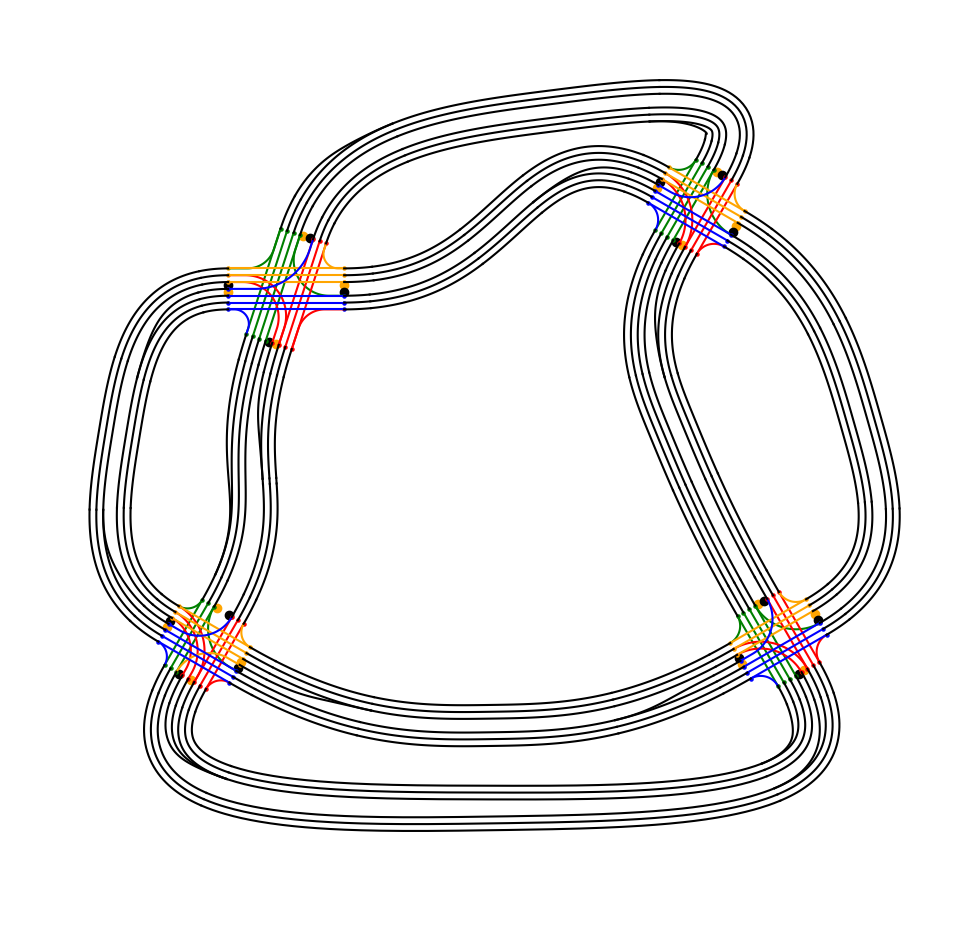

(-56.73647262378687, 269.1740115297987, -81.95144965274972, 220.08146697476806)

In [4]:
render(urbanMap)

# Generate Connecting Roadway Geometry (between intersections)

In [ ]:
# patch predecessors
for (lane_id, lane) in urbanMap.lanes
    for predecessor_id in lane.predecessors
        predecessor = urbanMap.lanes[predecessor_id]
        push!(predecessor.successors, lane_id)
    end
end

In [ ]:
frontier = Set()
explored = Set()

lane_id = rand([k for (k,v) in urbanMap.lanes])
# lane_id = rand(unexplored)
push!(frontier, lane_id)

while length(frontier) > 0
    lane_id = pop!(frontier)
    push!(explored, lane_id)
    lane = urbanMap.lanes[lane_id]
    union!(frontier, union(lane.predecessors, lane.successors, lane.neighborsLeft, lane.neighborsRight))
    setdiff!(frontier, explored)
end
PyPlot.figure(figsize=[11.5,8])
for (lane_id, lane) in urbanMap.lanes
    color="black"
    z=1
    if lane_id in explored
        color="red"
        z=2
    end
    PyPlot.plot(lane.centerLine.x, lane.centerLine.y, c=color, zorder=z)
end
PyPlot.axis("off")
PyPlot.axis("equal")

# Dubbins stuff

In [ ]:
# pt₁ = [rand();rand()]
# pt₂ = 10*[rand();rand()]
# θ = atan2((pt₂-pt₁)[1],(pt₂-pt₁)[2])
# θ₁ = θ + (rand() - 0.5) * 3*π/4
# θ₂ = θ + sign(θ - θ₁)*rand() * π/2

pt₁ = [1;-5]
pt₂ = [8;-3]
θ₁ = 2π/8
θ₂ = -π/4

pt₀ = pt₁ - 3*[cos(θ₁);sin(θ₁)]
pt₃ = pt₂ + 3*[cos(θ₂);sin(θ₂)]

x,y = Dubbins(pt₁,pt₂,θ₁,θ₂)
PyPlot.figure(figsize=[11,4])
PyPlot.subplot(1,2,1)
PyPlot.scatter([pt₁[1], pt₂[1]],[pt₁[2], pt₂[2]])
PyPlot.plot([pt₁[1], (Rot(θ₁)*[-1;0]+pt₁)[1]],[pt₁[2], (Rot(θ₁)*[-1;0]+pt₁)[2]])
PyPlot.plot([pt₂[1], (Rot(θ₂)*[1;0]+pt₂)[1]],[pt₂[2], (Rot(θ₂)*[1;0]+pt₂)[2]])
PyPlot.scatter(x,y)
PyPlot.axis("equal")

x,y = ExtendedDubbins(pt₀,pt₁,pt₂,pt₃;θ₁=θ₁,θ₂=θ₂)
PyPlot.subplot(1,2,2)
PyPlot.scatter([pt₁[1], pt₂[1]],[pt₁[2], pt₂[2]])
PyPlot.plot([pt₀[1], pt₁[1]],[pt₀[2], pt₁[2]])
PyPlot.plot([pt₂[1], pt₃[1]],[pt₂[2], pt₃[2]])
PyPlot.scatter(x,y)
PyPlot.axis("equal")